<center>

## An Evaluation of the Impact of Leading Pedestrian Interval Signals in NYC


<br><br>
<center>
By
<br><br>
Jeremy J. Sze
<br><br>

<center>
Submitted in partial fulfillment<br>
of the requirements for the degree of<br>
Master of Arts in Economics, Hunter College<br>
The City University of New York<br>
2019

<br><br>
<center>
Thesis Sponsor: <br><br>
    Professor Jonathan Conning<br>
    Professor Partha Deb

### Abstract

I evaluated the impact of the phased introduction of Leading Pedestrian Interval Signals (LPIs) on collision and injury outcomes at 12,987 signalized traffic intersections in New York City over the course of 25 quarters from 2012 to 2018. An intersection is treated when a LPIs is installed to give pedestrians lead time to cross the street before vehicles are allowed to move. Outcomes from NYPD’s Motor Vehicle Collisions data were matched to signalized intersections. I hypothesize that LPIs would reduce collisions and reduce injuries for pedestrians at intersections. A difference in difference fixed effects panel regression was used to identify the causal effect of introducing LPIs. This approach accounts for the problem that unobserved heterogeneity that might bias results in simpler regression approaches. The analysis suggests that the introduction of LPIs decreased quarterly collision counts by 5.45% and decreased the quarterly number of pedestrians injured by 14.7% over the same intervention period. LPIs appears to be effective in reducing both collisions and injuries.

### Acknowledgements
Throughout the analysis and writing of my thesis I had received a great deal of support and assistance. I would like to thank my thesis advisor, Professor Jonathan Conning, who helped me develop my data processing pipeline and analytical plan. Next, I would like to thank Professor Partha Deb and Professor Matthew Baker for their valuable time and input during the model development stage and Professor Randall Filer for his guidance in the bi-weekly thesis workshops. In addition, I would like to thank my sister, Jocelyne Sze and friend Dennis Kim for proofreading my thesis drafts. Finally, I would like to thank my wife, Maria Eugenia Brandão for her wise counsel and support as we discussed ideas for my thesis. 

### Contents

1. Signal intersection (stata)
2. LPIs (python)
3. Linking Signal intersection to other data (python)
4. NYPD Motor Vehicle Collision data
    - download (stata)
    - clean (stata)
    - link to signal intersection (python)
5. Calculate collision outcomes (stata)
6. Set up panel data
    - monthly analytical panel (stata)
    - quarterly analytical panel (stata)
7. Convert analytical panel data into shapefile (python)
8. Thiessen Polygons (python)
9. Non-spatial Analysis (stata)
10. Spatial Analysis (stata)

### 1. Signal intersection
- Stata
- Explore duplicates
- Create intersection IDS

#### About "signal_controllers.csv"
This was obtained through a request to the DOT Commissioner.

In [1]:
cd "..\input_data\DOT_traffic_signals_Oct_2018\"

C:\Users\jerem\Box Sync\Policy Evaluation\input_data\DOT_traffic_signals_Oct_2018


In [2]:
import delimited using "signal_controllers.csv",clear stringcols(_all)

(6 vars, 13,278 obs)


In [4]:
describe


Contains data
  obs:        13,278                          
 vars:             7                          
 size:     2,376,762                          
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
y               str22   %22s                  Y
x               str22   %22s                  X
st1_name        str31   %31s                  ST1_Name
st2_name        str32   %32s                  ST2_Name
st3_name        str35   

In [3]:
duplicates tag y x, gen(dup)
tab dup



Duplicates in terms of y x


        dup |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |     13,156       99.08       99.08
          1 |        112        0.84       99.92
          2 |          3        0.02       99.95
          6 |          7        0.05      100.00
------------+-----------------------------------
      Total |     13,278      100.00


In [5]:
duplicates drop y x, force


Duplicates in terms of y x

(64 observations deleted)


In [7]:
gen intersection_id = _n, before(y)

Check to remember why we dropped intersection_id 2799

In [8]:
// Nonsensical coordinates
drop if intersection_id ==  2799

(1 observation deleted)


In [ ]:
save "signal_controllers_clean.dta"

### 2. LPIs 
- In python
- Explore the LPIs data using python's Geopandas library
- Create IDs
- Save into Stata dta

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree

%matplotlib inline
import os
os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share" #window

In [10]:
cd

C:\Users\jerem


Opening the Vision Zero Leading Pedestrian Interval Signals shapefile

In [11]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\VZV_Leading Pedestrian Interval Signals\geo_export_0c63b43f-83c0-4834-aa91-2c564c1bff2c.shp"

In [19]:
lpis_df = gpd.read_file(fp)

In [20]:
lpis_df.head(3)

,cross_stre,date_insta,time_insta,lat,long,main_stree,geometry
0,Dreiser loop East,2018-08-01,00:00:00.000,40.878465,-73.828273,Co-op City Blvd,POINT (-73.82827338235253 40.87846542795222)
1,West 119 St,2018-08-08,00:00:00.000,40.803958,-73.948271,Lenox Avenue,POINT (-73.94827133431397 40.80395846158952)
2,West 120 St,2018-08-08,00:00:00.000,40.804587,-73.947812,Lenox Avenue,POINT (-73.94781210658503 40.80458679730486)


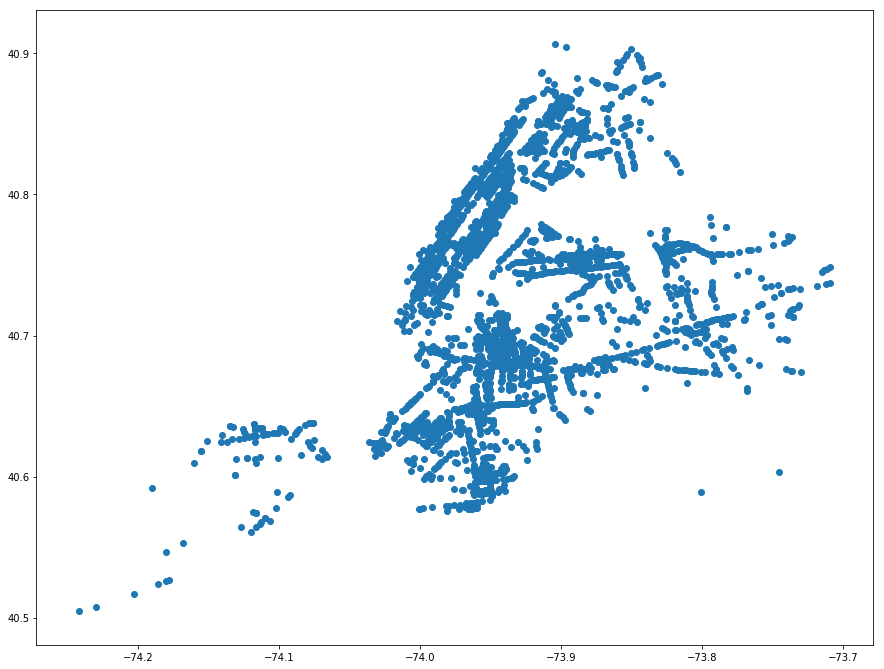

In [21]:
lpis_df.plot(figsize=(15, 15))

First, we have to check the CRS (coordinate reference system)  of the shapefile. This is important because all the other shapefiles have to be on the same projection in order to do spatial joins and identify nearest neighbors. For more information on projections, you can watch this [short video](https://youtu.be/KUF_Ckv8HbE) and read this [document](https://www.earthdatascience.org/courses/earth-analytics-python/spatial-data-vector-shapefiles/intro-to-coordinate-reference-systems-python/) from [Earthdatascience.org](https://www.earthdatascience.org).


To see the crs of lpis_df, we use geodataframe.crs

In [14]:
lpis_df.crs

{'init': 'epsg:4326'}

EPSG 4326 is the coordinate system for the world. It is also known as WGS84. When you have a longitude and latitude from this CRS, you can copy and paste it into Google Maps to find that location. 

Since we are working with New York City only, we prefer to use a projection that more accurately protrays the shape of NYC. We will reproject lpis_df to EPSG 2263 (NAD83 / New York Long Island (ftUS)).

In [15]:
lpis_df = lpis_df.to_crs({'init': 'epsg:2263'})

We can see that lpis_df now has the right projection.

In [16]:
lpis_df.crs

{'init': 'epsg:2263'}

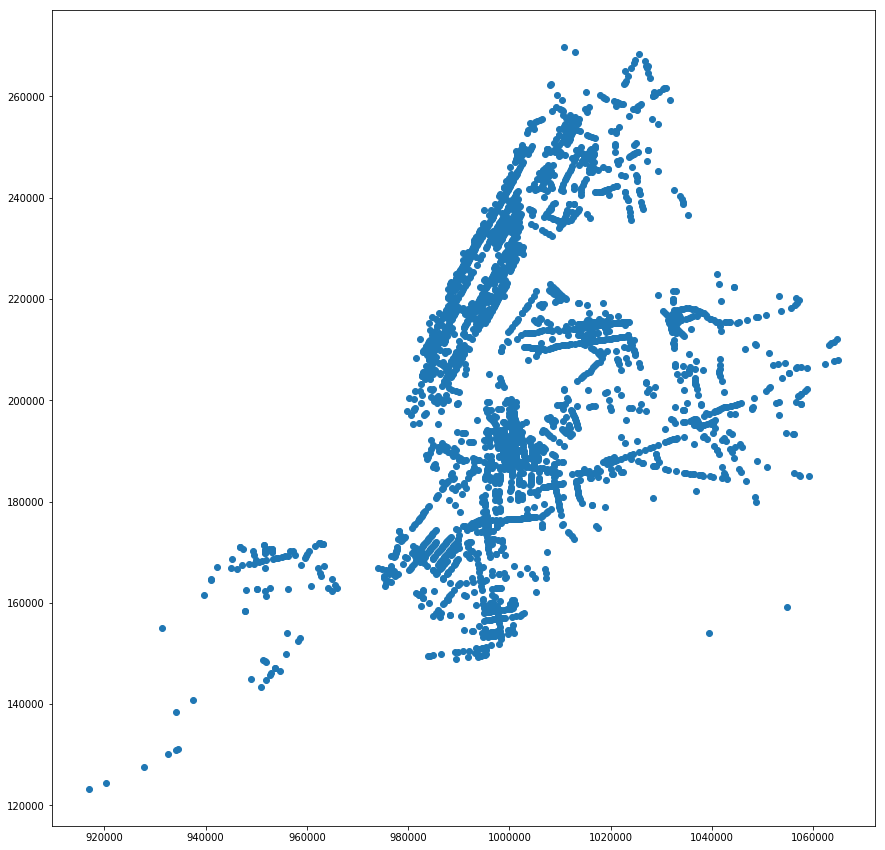

In [18]:
lpis_df.plot(figsize=(15, 15))

If you look at both plots again, you will notice that the axes labels are different. This is due to the different CRS.

I create IDs in the dataframe, since lpis_df has no ID variables.

In [23]:
lpis_df['LPIS_ID'] = lpis_df.index
lpis_df.head(3)

,cross_stre,date_insta,time_insta,lat,long,main_stree,geometry,LPIS_ID
0,Dreiser loop East,2018-08-01,00:00:00.000,40.878465,-73.828273,Co-op City Blvd,POINT (-73.82827338235253 40.87846542795222),0
1,West 119 St,2018-08-08,00:00:00.000,40.803958,-73.948271,Lenox Avenue,POINT (-73.94827133431397 40.80395846158952),1
2,West 120 St,2018-08-08,00:00:00.000,40.804587,-73.947812,Lenox Avenue,POINT (-73.94781210658503 40.80458679730486),2


Next, I want to export the dataframe to a Stata dta file. Objects need to be converted to str. 

In [24]:
str_cols = list(lpis_df.select_dtypes(include=['object']).columns)
for col in str_cols:
    lpis_df[col] = lpis_df[col].astype(str)

In [ ]:
fp =  r"C:\Users\jerem\Box Sync\Policy Evaluation\working_data\VZV_LPIS_data.dta"
lpis_df.to_stata(fp)

### 3. Linking Signal intersection to other data
- In python
-


Define a function to obtain IDs of nearest neighbors and distance measure.

In [ ]:
# ckdnearest function
# from "https://gist.github.com/jhconning/63a34a51acff83d116adc52308faf240"
def ckdnearest(gdA, gdB, bcol):
    """
    This function takes geodataframes: `gdA` and `gdB` and 
    a column name `bcol`. Both dataframes are assumed to have a `geometry` column. 
    It finds the nearest neighbor from each location in `gdA` to a 
    nearest neighbor in `gdB`.  

    It returns a two-column pandas dataframe with a 'distance' (here rounded to nearest foot)
    and the value of the `bcol` in `gdB'  (e.g. 'school_name')
    """
    
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist.astype(int),
                             'bcol' : gdB.loc[idx, bcol].values })
    return df

Read the 

### 4. NYPD Motor Vehicle Collision data
#### 4.a. download 
(stata)
#### 4.b. clean 
(stata)
#### 4.c. link to signal intersection 
(python)


### 5. Calculate collision outcomes 
(stata)


### 6. Set up panel data
#### 6.a. monthly analytical panel 
(stata)
#### 6.b. quarterly analytical panel 
(stata)


### 7. Convert analytical panel data into shapefile 
(python)


### 8. Thiessen Polygons
(python)


### 9. Non-spatial Analysis 
(stata)


### 10. Spatial Analysis 
(stata)